# Bias Variance Decomposition

revision: 78571a2

The goal of this exercise is to verify the bias variance decomposition for the relationship
$$
Y = f(X) + \epsilon
$$
To ease code, we used $f$ instead of $h^{\star}$ as in the script.
Try to follow the code and then implement a variant of it on your own.

First, we generate some data according to the forumla $Y = f(X) + \epsilon$, where we will use $\epsilon \sim N(0, \text{noise\_std}^2)$, i.e. $\epsilon$ will be normal distributed with standard deviation `noise_std`.

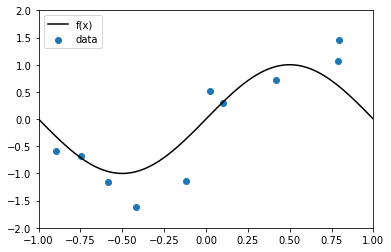

In [1]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np

rng = np.random.RandomState(3)  # fix rng
m = 10  # number of observations
noise_std = 0.5  # standard deviation of N(0,std) noise


def f(x):
    """True function $h^{\star}$"""
    return np.sin(x * np.pi)


def sample_data(x, noise_std, rng):
    """$Y = h^{\star}(X) + \epsilon$"""
    return f(x) + rng.randn(*x.shape) * noise_std


# create data set
t = np.linspace(-1, 1, 100)
X = 2 * (rng.rand(m) - 0.5)
y = sample_data(X, noise_std, rng)

plt.plot(t, f(t), color='k', label='f(x)')
plt.scatter(X, y, label='data')
plt.xlim([-1, 1])
plt.ylim([-2, 2])
plt.legend();

In [2]:
def ridge_poly(X, y, lam, degree=m):
    """Polynomial ridge regression"""

    def poly_feat(X, degree):
        return np.array([X ** i for i in range(degree, -1, -1)]).T

    X = poly_feat(X, degree)
    w = np.linalg.solve(np.dot(X.T, X) + np.eye(degree + 1) * lam, np.dot(X.T, y))
    return lambda X: np.dot(poly_feat(X, degree), w.T)


def sq_error(ypred, y):
    """squared error"""
    return np.mean((ypred - y) ** 2)

Each model fit is based on a particular training set. Depending on the regularization, we observe under- or overfitting. To get an idea of how each of the models depend on particular data, we sample 50 independed sets and fit a model to each of them.

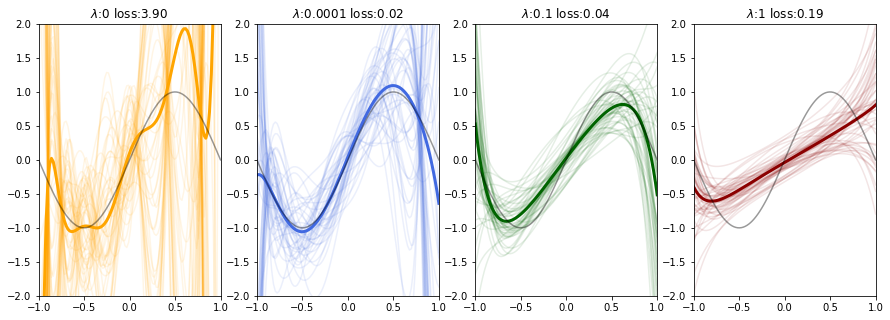

In [7]:
rng = np.random.RandomState(3)  # fix rng
COLORS = ['orange', 'royalblue', 'darkgreen', 'darkred']
runs = 50
lambdas = [0, .0001, .1, 1]  # regularization parameters

yhats = defaultdict(list)
for run in range(50):
    y = sample_data(X, noise_std, rng)
    for lam in lambdas:
        h = ridge_poly(X, y, lam)
        yhats[lam].append(h(t))

fig, axs = plt.subplots(1, len(lambdas), figsize=(15, 5))
for i, lam in enumerate(lambdas):
    plt.sca(axs[i])
    # plot individual fits
    for j, yhat in enumerate(yhats[lam]):
        plt.plot(t, yhat, alpha=.1, color=COLORS[i])
    # plot mean
    Eh = np.mean(yhats[lam], axis=0)  # E[h(X)]
    plt.plot(t, Eh, color=COLORS[i], linewidth=3)
    # plot true function
    plt.plot(t, f(t), alpha=.4, color='k', label='f(x)')
    plt.xlim([-1, 1])
    plt.ylim([-2, 2])
    plt.title(f'$\lambda$:{lam} loss:{sq_error(Eh, f(t)):.2f}')

Based on the samples above, we now decompose the generalization error into bias, variance and noise.
If we are correct, then these values add up to the generalization error.

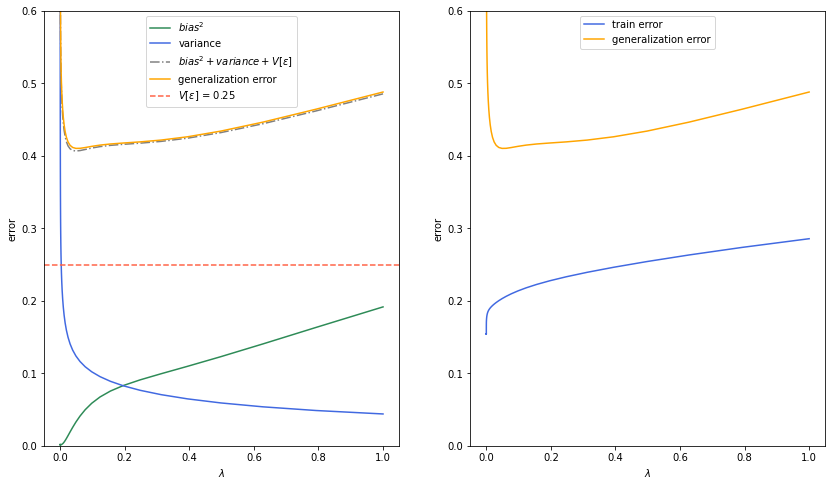

In [4]:
rng = np.random.RandomState(1)  # fix rng

m = 35  # data set size
noise_std = 0.5  # noise standard deviation
runs = 200  # number of runs
n_train = int(np.ceil(m * .8))  # number of training points

# create training and test inputs (same for each run)
x = rng.permutation(np.linspace(-1, 1, m))
x_train = x[:n_train]
x_test = x[n_train:]

# create new training and test labels for each run
y_train = [sample_data(x_train, noise_std, rng) for _ in range(runs)]
y_test = [sample_data(x_test, noise_std, rng) for _ in range(runs)]

# model complexities to use
lambdas = np.exp(np.linspace(np.log(1e-10), np.log(1), 100))


def bias_var_decomp(lam):
    '''calculate bias variance decomposition based on regularization term lambda'''
    pred_train = np.zeros((runs, len(x_train)))
    pred_test = np.zeros((runs, len(x_test)))
    # average over runs
    for run in range(runs):
        # train model
        h = ridge_poly(x_train, y_train[run], lam)

        # make predictions on train set
        pred_train[run, :] = h(x_train)

        # make predictions on test set
        pred_test[run, :] = h(x_test)

    Eh = np.array(pred_test).mean(0)  # E[h(X)]
    bias = np.mean((Eh - f(x_test)) ** 2)  # (E[h(X)] - hstar(X))^2
    variance = np.mean((Eh - pred_test) ** 2)  # (E[h(X)] - h(X))^2
    train_error = sq_error(pred_train, y_train)
    test_error = sq_error(pred_test, y_test)
    return bias, variance, train_error, test_error


train_errors = np.zeros((len(lambdas),))
test_errors = np.zeros((len(lambdas),))
biases = np.zeros((len(lambdas),))
variances = np.zeros((len(lambdas),))

# loop over model complexities
for i, lam in enumerate(lambdas):
    biases[i], variances[i], train_errors[i], test_errors[i] = bias_var_decomp(lam)

# create plots
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

## bias^2 + variance
plt.sca(axs[0])
plt.plot(lambdas, biases, color='seagreen', label='$bias^2$')
plt.plot(lambdas, variances, color='royalblue', label='variance')
plt.plot(lambdas, biases + variances + noise_std ** 2, linestyle='-.', color='gray',
         label='$bias^2 + variance + V[\epsilon]$')
plt.plot(lambdas, test_errors, label='generalization error', color='orange')
plt.axhline(noise_std ** 2, color='tomato', linestyle='--', label=f'$V[\epsilon]$ = {round(noise_std ** 2, 3)}')
plt.xlabel('$\lambda$')
plt.ylabel('error')
plt.ylim([0, .6]);
plt.legend(loc='upper center')

## train / test error
plt.sca(axs[1])
plt.plot(lambdas, train_errors, label='train error', color='royalblue')
plt.plot(lambdas, test_errors, label='generalization error', color='orange')
plt.ylim([0, .6]);
plt.xlabel('$\lambda$')
plt.ylabel('error')
plt.legend(loc='upper center');

Question: What is the generalization error of the best possible model $h^\star$ (named $f$ here in the code)?

--> ~0.41 for $\lambda = 0.01$

Task: Perfom the same analysis for unregularized polynomial linear regression. That means your model complexity is the polynomial degree instead of $\lambda$.

In [8]:
def poly_lin_reg(X, y, degree):
    """unregularized polynomial linear regression"""

    def poly_feat(X, degree):
        return np.array([X ** i for i in range(degree, -1, -1)]).T

    X = poly_feat(X, degree)
    w = np.linalg.solve(np.dot(X.T, X), np.dot(X.T, y))
    return lambda X: np.dot(poly_feat(X, degree), w.T)

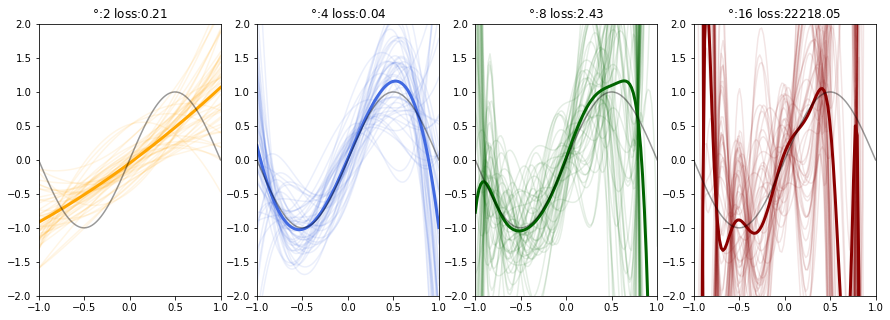

In [11]:
rng = np.random.RandomState(3)  # fix rng
COLORS = ['orange', 'royalblue', 'darkgreen', 'darkred']
runs = 50
degrees = [2, 4, 8, 16]  # regularization parameters

yhats = defaultdict(list)
for run in range(50):
    y = sample_data(X, noise_std, rng)
    for deg in degrees:
        h = poly_lin_reg(X, y, deg)
        yhats[deg].append(h(t))

fig, axs = plt.subplots(1, len(degrees), figsize=(15, 5))
for i, deg in enumerate(degrees):
    plt.sca(axs[i])
    # plot individual fits
    for j, yhat in enumerate(yhats[deg]):
        plt.plot(t, yhat, alpha=.1, color=COLORS[i])
    # plot mean
    Eh = np.mean(yhats[deg], axis=0)  # E[h(X)]
    plt.plot(t, Eh, color=COLORS[i], linewidth=3)
    # plot true function
    plt.plot(t, f(t), alpha=.4, color='k', label='f(x)')
    plt.xlim([-1, 1])
    plt.ylim([-2, 2])
    plt.title(f'$\degree$:{deg} loss:{sq_error(Eh, f(t)):.2f}')

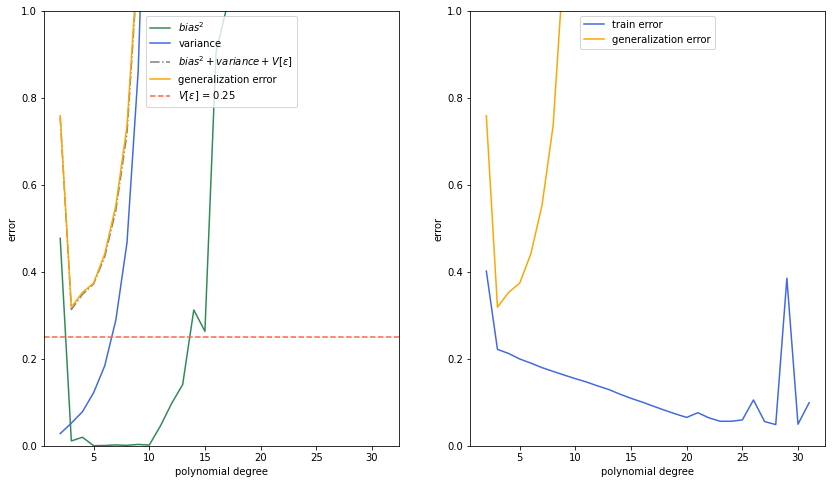

In [26]:
rng = np.random.RandomState(1)  # fix rng

m = 35  # data set size
noise_std = 0.5  # noise standard deviation
runs = 200  # number of runs
n_train = int(np.ceil(m * .8))  # number of training points

# create training and test inputs (same for each run)
x = rng.permutation(np.linspace(-1, 1, m))
x_train = x[:n_train]
x_test = x[n_train:]

# create new training and test labels for each run
y_train = [sample_data(x_train, noise_std, rng) for _ in range(runs)]
y_test = [sample_data(x_test, noise_std, rng) for _ in range(runs)]

# model complexities to use
degrees = range(2, 32)


def bias_var_decomp(deg):
    '''calculate bias variance decomposition based on the polynomial degree'''
    pred_train = np.zeros((runs, len(x_train)))
    pred_test = np.zeros((runs, len(x_test)))
    # average over runs
    for run in range(runs):
        # train model
        h = poly_lin_reg(x_train, y_train[run], deg)

        # make predictions on train set
        pred_train[run, :] = h(x_train)

        # make predictions on test set
        pred_test[run, :] = h(x_test)

    Eh = np.array(pred_test).mean(0)  # E[h(X)]
    bias = np.mean((Eh - f(x_test)) ** 2)  # (E[h(X)] - hstar(X))^2
    variance = np.mean((Eh - pred_test) ** 2)  # (E[h(X)] - h(X))^2
    train_error = sq_error(pred_train, y_train)
    test_error = sq_error(pred_test, y_test)
    return bias, variance, train_error, test_error


train_errors = np.zeros((len(degrees),))
test_errors = np.zeros((len(degrees),))
biases = np.zeros((len(degrees),))
variances = np.zeros((len(degrees),))

# loop over model complexities
for i, deg in enumerate(degrees):
    biases[i], variances[i], train_errors[i], test_errors[i] = bias_var_decomp(deg)

# create plots
fig, axs = plt.subplots(1, 2, figsize=(14, 8))

## bias^2 + variance
plt.sca(axs[0])
plt.plot(degrees, biases, color='seagreen', label='$bias^2$')
plt.plot(degrees, variances, color='royalblue', label='variance')
plt.plot(degrees, biases + variances + noise_std ** 2, linestyle='-.', color='gray',
         label='$bias^2 + variance + V[\epsilon]$')
plt.plot(degrees, test_errors, label='generalization error', color='orange')
plt.axhline(noise_std ** 2, color='tomato', linestyle='--', label=f'$V[\epsilon]$ = {round(noise_std ** 2, 3)}')
plt.xlabel('polynomial degree')
plt.ylabel('error')
plt.ylim([0, 1.]);
plt.legend(loc='upper center')

## train / test error
plt.sca(axs[1])
plt.plot(degrees, train_errors, label='train error', color='royalblue')
plt.plot(degrees, test_errors, label='generalization error', color='orange')
plt.ylim([0, 1.]);
plt.xlabel('polynomial degree')
plt.ylabel('error')
plt.legend(loc='upper center');